# Deriving [Anand et al's (2003)](http://onlinelibrary.wiley.com/doi/10.1029/2002PA000846/abstract) Foraminiferal Mg/Ca-Temperature Relationship
*by [Oscar Branson](mailto:oscarbranson@gmail.com)*

Anand et al (2003) established a multi-species foraminiferal Mg/Ca-temperature relationship.
It is one of the most commonly used calibrations in studies that apply the Mg/Ca palaeothermometer.
It is almost impossible to hear about the Mg/Ca palaeothermometer without seeing their iconic figure:

![Fig6](figures/Anand2003_Fig6.png)

This Notebook goes through the methods behind this relationship, to demonstrate the utility of Python in scientific data processing, and the importance of Data Stewardship.

## Anand et al's Methods:
Their paper states:

> **Estimation of $\delta^{18}O$ of Seawater and Equilibrium Calcite, and Isotopic Calcification Temperature**
> 
> Temperature and salinity data from Bermuda biological station "S" (e.g., Figure 1) were used to calculate d18O of seawater ($\delta^{18}O_W$) and to predict d18O of calcite ($\delta^{18}O_C$) formed in equilibrium with seawater, seasonally and over 0 – 800 m, during the period for which the sediment trap was deployed. The reason for calculating equilibrium calcite $\delta^{18}O$ was to compare with measured $\delta^{18}O$ to estimate depth habitats. The isotopic temperatures based on the $\delta^{18}O_W$ at different water depths and measured $\delta^{18}O$ in foraminiferal calcite are used for the Mg calibration.
>
> $\delta^{18}O_W$, expressed as % deviation from the standard mean ocean water (SMOW) scale, was calculated from the station "S" salinity data using the equation of Duplessy et al. [1991], itself obtained from $\delta^{18}O_W$ and salinity for water samples collected in the upper 250 m of the Atlantic Ocean during the GEOSECS expedition:
> $$\delta^{18}O_W = -19.264 + 0.558 * salinity $$
>
> Other relationships exist in the literature but values for $\delta^{18}O_W$ obtained using equation (1) were the closest to measured $\delta^{18}O_W$ available for 32°N 64°W [Schmidt et al., 1999].
> 
> ... [*section on calculating equilibrium $\delta^{18}O_C$, which we are not concerned with here*]
> 
> Isotopic calcification temperatures of the foraminifera were calculated, using the paleotemperature equation, from measured $\delta^{18}O_C$ (from the planktonic foraminifera) and estimates of $\delta^{18}O_W$ (as described above) based on their habitat depths defined as in sections 3.3 and 3.4:
>
> $$ T = 16.9 - 4.38 (\delta^{18}O_C - (\delta^{18}O_W - 0.27)) + 0.1 (\delta^{18}O_C - (\delta^{18}O_W - 0.27))^2$$

**Note:** Equations are given to relate the hydrographic measurements to calcification temperature, but the method used to derive estimates for individual samples from the hydrographic data is not given. We will return to this later.

## Data Availability
Raw foraminiferal Mg/Ca and $\delta^{18}O_C$ values are provided both as an [electronic supplement to the manuscript](http://onlinelibrary.wiley.com/store/10.1029/2002PA000846/asset/supinfo/palo1030-sup-0001-readme.txt?v=1&s=721948dddeb9803ec0c494cb35a2b3ec49feda90), and through the [Pangea database](https://doi.pangaea.de/10.1594/PANGAEA.740070). We will work with the latter, because it has a stable URL that should not change with time.

Hydrographic data for Bermuda Biological Station S were more difficult to track down, but are available through the [BATS FTP website](http://batsftp.bios.edu/Hydrostation_S/bottle/hydrostation_bottle.txt).

### Stylistic Note
To highlight the use of specific Python libraries for specific tasks, I import them at the start of each section.
Normally, you would import them all at the *start* of your code.

## Step 1: Get Data

In [40]:
import os  # basic operating system functions.
from urllib import request  # module for fetching urls from the internet.

In [41]:
# if it doesn't already exist, make data directory
if not os.path.exists('data/'):
    os.mkdir('data/')

In [42]:
# Download Anand data from Pangea, if not already present
url_An = 'https://doi.pangaea.de/10.1594/PANGAEA.740070?format=textfile'

if not os.path.exists('data/Anand2003_Pangea_data.txt'):
    request.urlretrieve(url_An, 'data/Anand2003_Pangea_data.txt')

In [43]:
# Download 'Station S' hydrographic data, if not already present
url_SS = 'http://batsftp.bios.edu/Hydrostation_S/bottle/hydrostation_bottle.txt'

if not os.path.exists('data/Anand2003_StationS_bottle.txt'):
    request.urlretrieve(url_SS, 'data/Anand2003_StationS_bottle.txt')

## Step 2: Load Data

In [44]:
import pandas as pd  # module for handling data tables
import numpy as np  # module for general numerical work
import re  # 'regular expression' module

### Load Anand Data

**Note 1:** The Pangea data is in a really awkward format, with a new row for each individual foram measurement.
Various dataframe gymnastics required to get it in a sensible format.

**Note 2:** There are numerous typos and inconsistencies in species names, which had to be fixed.

In [118]:
# load Pangea data
ad = pd.read_table('data/Anand2003_Pangea_data.txt', skiprows=41)

# create a regular expression to parse information in column names
rec = re.compile('([GNPO]\. [a-z \.]+) (Mg\/Ca|d18O) \[(.*)\] ?\(?([a-z ]+)?\)?')
# for an explanation, see: https://regex101.com/r/lLWRIL/1

# apply regular expression to column names
cs = []
for c in ad.columns:
    m = rec.match(c)
    if m:
        g = m.groups()
        # TYPO: fix inconsistent labelling and misspelling of of G. crassiformis
        if g[0] == 'G. crassaf.':
            g = ('G. crassiformis', g[1], g[2], g[3])
        if g[0] == 'G. crassaformis':
            g = ('G. crassiformis', g[1], g[2], g[3])
        # TYPO: fix inconsistent G sacculifer labelling
        if g[0] == 'G. sacculifer sac':
            g = ('G. sacculifer (with sac)', g[1], g[2], g[3])
        if g[-1] is None and g[0] == 'G. sacculifer':
            g = ('G. sacculifer (without sac)', g[1], g[2], g[3])
        # TYPO: fix abbreviated P obliquloculata name
        if g[0] == 'P. obliqu.':
            g = ('P. obliquiloculata', g[1], g[2], g[3])
        # if present, combine information in brackets after units with species name
        if g[-1] is not None:
            cs.append((g[0] + ' (' + g[-1] + ')', g[1], g[2]))
        else:
            cs.append(g[:-1])
    else:
        cs.append([])
# manually fix first three columns (date and size ranges)
cs[0] = ('Date', '', '')
cs[1] = ('size_min', '', '')
cs[2] = ('size_max', '', '')

# cs is now a list of tuples, containing (species, measurement, unit)
# these tuples can be converted into a hierarchical 'multi-index'
ad.columns = pd.MultiIndex.from_tuples(cs)
ad.columns = ad.columns.droplevel(2)  # remove units - don't need this information

# sort columns, to facilitate later operations
ad.sort_index(1, inplace=True)

# convert dates to 'datetime' objects (i.e. times that the computer can understand)
ad.loc[:,'Date'] = pd.to_datetime(ad.Date)

# TYPO: correct value where 'size_max' is incorrect (501, should be 500)
ad.loc[ad.size_max == 501, 'size_max'] = 500

# combine min and max sizes into 'size_fraction' descriptor
ad.loc[:, 'size_fraction'] = (ad.loc[:, 'size_min'].map(str) +
                              '-' +
                              ad.loc[:, 'size_max'].map(str))
ad.drop(['size_min', 'size_max'], axis=1, inplace=True)  # remove min and max size columns

# aggregate values for individual Dates and size fractions into single rows
ad = ad.groupby(('Date', 'size_fraction')).mean()

# re-arrange indices into useful format.
ad = ad.unstack(1).T.unstack(0).T  # note: '.T' transposes the dataframe
# use of 'unstack' here is complex, and determined by trial and error

# get row indices in better order (species before data)
ad = ad.swaplevel()
ad.sort_index(inplace=True)  # sort index

# remove empty rows
ad.dropna(how='all', inplace=True)

**Moral:** This data was *horribly* formatted, and contained numerous inconsistencies and typos. It definitely did not 'just work' - lots of import gymnastics required to get it in useable form. **Put some effort into formatting your data, and making it easily useable!**

### Load Anand Table 2

Transcribed directly from paper.

In [119]:
# This is a 'dict', composed of {key: value} pairs
dh = {'G. aequilateralis': (50, 75),
      'G. conglobatus': (50, 100),
      'G. crassiformis': (500, 800),
      'G. hirsuta': (500, 800),
      'G. inflata': (100, 400),
      'G. ruber (pink)': (0, 25),
      'G. ruber (white)': (0, 50),
      'G. sacculifer (with sac)': (0, 50),
      'G. sacculifer (without sac)': (0, 50),
      'G. truncatulinoides': (200, 500),
      'N. dutertrei': (50, 100),
      # Note: This O universa depth range is definitely wrong. We hand-catch them at ~5 m!
      'O. universa (thick test)': (50, 100),
      'O. universa (thin test)': (50, 100),
      'P. obliquiloculata': (50, 100)}

#### Combine Depth Ranges with Anand Data

In [120]:
# create empty columns
ad.loc[:, ('depthrange', 'min')] = np.nan
ad.loc[:, ('depthrange', 'max')] = np.nan

# assign depth-ranges to empy columns
for i, r in dh.items():    
    ad.loc[i, ('depthrange', ['min', 'max'])] = r

### Load Station S Data

**Note:** Column names had to be read in and assigned separately, because of mixed formatting - data are tab-separated, and columns are a mixture of tabs *and* commas.

In [121]:
# load Station S Bottle Data
ss = pd.read_table('data/Anand2003_StationS_bottle.txt', skiprows=30, sep='\t', header=None)

# read, clean up and assign column names
with open('data/Anand2003_StationS_bottle.txt') as f:
    li = f.readlines()
cols = [cn.strip() for cn in li[29].replace('\t', '').replace('T ', '').split(',')]
ss.columns = cols[:-1]

# create time index for rows
ss.index = pd.to_datetime(ss.yyyymmdd, format='%Y%m%d')

# replace -999 (missing data) values with 'nan' values
ss.replace(-999, np.nan, inplace=True)

# crop to date range of interest (specified in Anand et al)
ssub = ss.loc['1976-03-01':'1986-06-01', ('Temp', 'Sal1', 'Depth')]

## Step 3: 'Calculate $\delta^{18}O_W$ and predict $\delta^{18}O_C$'

No information given in paper on *how* this was done.

### First, look at the data.

In [122]:
import matplotlib.pyplot as plt  # plotting library
# command to tell the notebook to display plots 'inline'
%matplotlib inline
plt.rcParams['figure.dpi'] = 120

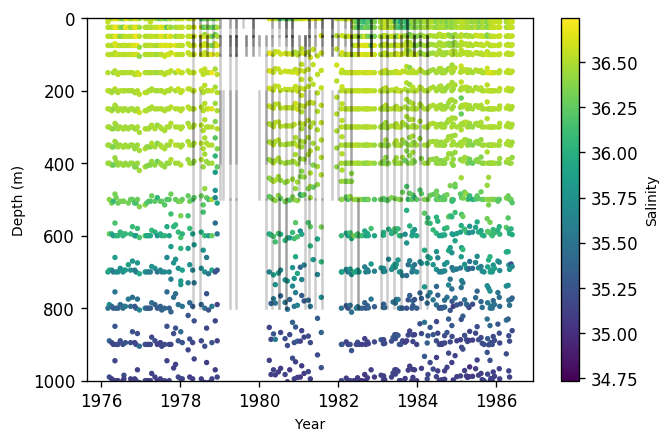

In [123]:
fig, ax = plt.subplots(1, 1)

# plot bottle data
cm = ax.scatter(ssub.index, ssub.Depth, s=5, c=ssub.Sal1)

# plot depth ranges of samples forams
for d, r in ad.iterrows():
    if not all(r.loc[['Mg/Ca', 'd18O']].isnull()):
        ax.plot([d[1]] * 2,
                [r.loc[('depthrange', 'min')], r.loc[('depthrange', 'max')]],
                c='k', alpha=0.2)

ax.invert_yaxis()
ax.set_ylim(0, 1000)
ax.invert_yaxis()
ax.set_xlabel('Year')
ax.set_ylabel('Depth (m)')
fig.colorbar(cm, label='Salinity')

### Problem: Big gap in bottle data!
Interpolation method not specified in manuscript.

'Nearest Neighbour' interpolation not ideal with large gaps and likely seasonal cyclicity.

Fit a function, and use that instead?

## 4. Interpolate Salinity

In [145]:
from scipy import optimize as opt  # for fitting functions to data

In [146]:
# isolate subset of Station S data for fitting
# remove empty rows
ssub.dropna(0, inplace=True)
# remove data > 1200 m depth
ssub = ssub.loc[ssub.Depth < 1200, :]

# Convert data to uniform time scale - e.g. days since start of 1970 - 
# much easier to work with numbers than dates when fitting.

# convert bottle data timescale
td = ssub.index - pd.to_datetime('1970-01-01')
ssub.loc[:,'ddate'] = td.days
# convert Anand data timescale
ad.loc[:, 'ddate'] = (ad.index.get_level_values(1) - pd.to_datetime('1970-01-01')).days

#### Model salinity as empirical fn of time and depth.

$$
\begin{align}
Sal &= f(time, depth)
\end{align}
$$

In [126]:
# sigmoidal function to describe bottom of mixed layer
def sigm(x, a, k, x0):
    return a / (1 + np.exp(-k * (x - x0)))

# salinity function two polynomials for depth/time and a sinusoidal mixed layer
def sal_fn(vs, c, a1, a2, a3, b1, b2, b3, b4, b5, sa, sk, sd, ph, p):
    ddate, depth = vs
    # variability as a function of time
    cddate = np.polyval((a3,a2,a1,0), ddate)
    # variability as a function of depth
    cdepth = np.polyval((b5, b4,b3,b2,b1,0), depth)
    # Seasonal cycle varies mixed layer depth and surface conditions.
    # Surface conditions vary as a sinusoidal function with a ~6 month period.
    # Mixed layer depth modelled as a sigmoid function, which controls how
    # deep the surface conditions reach. The depth of the mixed layer is
    # also modelled as a sinusoidal function.
    season = (sigm(depth, sa, sk, sd * np.sin(np.pi * (ddate - ph) / p)) *  # sigmoid MLD fn
              np.sin(np.pi * (ddate - ph) / p))  # sinusoidal surface conditions
    
    out = c + cddate + cdepth + season  # combine all influences into model
    return out

# starting parameters
p0 = (36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
      151.1, 182.7)  # 151 day phase, 182 day period (i.e. 6 month)

# extract data  for fitting
vs = (ssub.ddate.values, ssub.Depth.values)
y = ssub.Sal1.values
# fit model
p, cov = opt.curve_fit(sal_fn, vs, y, p0, maxfev=6000)

### Plot Model

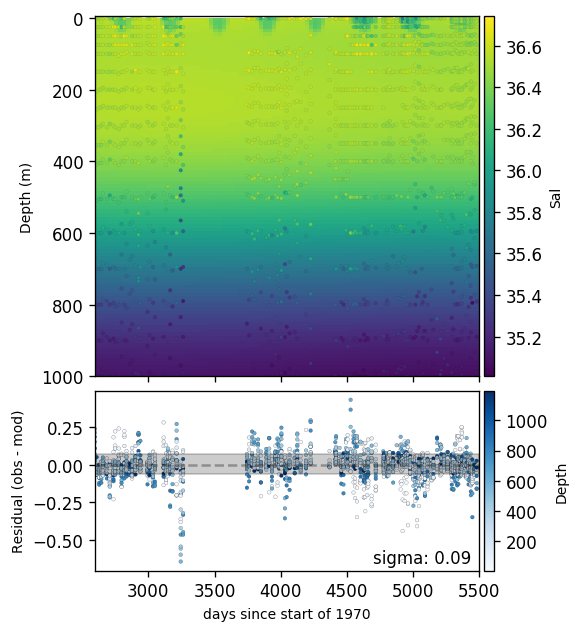

In [127]:
fig = plt.figure(figsize=[4,6])  # create figure

# add axis for main data/model plot
ax = fig.add_axes([.1,.4,.8,.5])
# plot station S bottle data
cm = ax.scatter(ssub.ddate, ssub.Depth, 
                c=ssub.Sal1,  # colour by salinity
                s=5, lw=0.3, edgecolor=(0,0,0,0.1))

# create gridded x/y data to plot model fit
xn = np.linspace(2400, 5500, 100)
yn = np.linspace(1,1000,100)
xng, yng = np.meshgrid(xn,yn)
# calculate gridded salinity
sal = sal_fn((xng, yng), *p)
# plot modeled salinity
ax.pcolormesh(xng, yng, sal,
              vmin=ssub.Sal1.min(), vmax=ssub.Sal1.max(),  # set colour limits
              zorder=-1)  # plot behind points (z order defines layers)

# axis labels, limits and invert y
ax.set_ylim(-5,1000)
ax.invert_yaxis()
ax.set_ylabel('Depth (m)')
ax.set_xticklabels([])  # remove x-tick labels, because same as lower panel

# create axis for colour scale
cax = fig.add_axes([.91,.4,.02,.5])
# add colourbar
fig.colorbar(cm, cax=cax, label='Sal')

# create axis for residuals
rax = fig.add_axes([.1,.13,.8,.25])

# calculate residuals
resid = ssub.Sal1 - sal_fn((ssub.ddate, ssub.Depth), *p)
# plot residuals
cm2 = rax.scatter(ssub.ddate, 
                  resid,
                  c=ssub.Depth,  # colour by depth
                  s=5, cmap=plt.cm.Blues, lw=0.1, edgecolor='k')

# calculate standard deviation of residuals
err = np.std(resid)

# plot zero and confidence interval limits of residuals
rax.axhline(0, c='k', ls='dashed', alpha=0.3, zorder=2)
rax.axhspan(*lims, zorder=1, color='k', alpha=0.2)
# note standard deviation on plot
rax.text(.98,.02,'sigma: {:.2f}'.format(err),
         transform=rax.transAxes, va='bottom', ha='right')
# set axis labels
rax.set_ylabel('Residual (obs - mod)')
rax.set_xlabel('days since start of 1970')

# create axis for colourbar
rcax = fig.add_axes([.91,.13,.02,.25])
# plot colourbar
fig.colorbar(cm2, cax=rcax, label='Depth')

# set xlim for both axes
for ax in [ax, rax]:
    ax.set_xlim(2600,5500)

### Apply model to calculate salinities for Anand data

In [128]:
ad.loc[:, ('sal', 'min')] = sal_fn((ad.loc[:,'ddate'].values,
                                    ad.loc[:, ('depthrange','min')].values), *p)
ad.loc[:, ('sal', 'max')] = sal_fn((ad.loc[:,'ddate'].values,
                                    ad.loc[:, ('depthrange','max')].values), *p)

ad.loc[:, ('sal', 'mid')] = sal_fn((ad.loc[:,'ddate'].values, 
                                    ad.loc[:, ('depthrange', ['min', 'max'])].mean(1).values), *p)

### Combine Uncertainties with estimates

In [129]:
import uncertainties.unumpy as un  # module for propagating uncertainties!

In [130]:
# 'err' is the standard deviation of the residuals, calculated in the plot above
ad.loc[:, ('sal', 'min')] = un.uarray(ad.loc[:, ('sal', 'min')].values, err)
ad.loc[:, ('sal', 'max')] = un.uarray(ad.loc[:, ('sal', 'max')].values, err)
ad.loc[:, ('sal', 'mid')] = un.uarray(ad.loc[:, ('sal', 'mid')].values, err)

## Calculate $\delta^{18}O_W$

In [147]:
def d18Ow(sal):
    """
    Anand et al (2003) Eqn 1.
    
    Parameters
    ----------
    sal : array-like
        Salinity.
    
    Returns
    -------
        Delta 18 Oxygen of the water.
    """
    return -19.264 + 0.558 * sal

In [148]:
ad.loc[:,('d18Ow', 'min')] = d18Ow(ad.loc[:, ('sal', 'min')])
ad.loc[:,('d18Ow', 'max')] = d18Ow(ad.loc[:, ('sal', 'max')])
ad.loc[:,('d18Ow', 'mid')] = d18Ow(ad.loc[:, ('sal', 'mid')])

## Calculate Calcification Temp

In [149]:
def cTemp(d18Oc, d18Ow):
    """
    Anand et al (2003) Eqn 3.
    
    Parameters
    ----------
    d18Oc : array-like
        Delta 18 Oxygen of foram calcite.
    d18Oc : array-like
        Delta 18 Oxygen of water the foram calcified in.

    Returns
    -------
    Temperature at which the foram calcified.
    """
    return (16.9 - 
            4.38 * (d18Oc - (d18Ow - 0.27)) + 
            0.1 *  (d18Oc - (d18Ow - 0.27))**2)

In [150]:
for v in ['min', 'max', 'mid']:
    for c in ad.d18O.columns:
        ad.loc[:,('Ctemp_' + v, c)] = cTemp(ad.loc[:, ('d18O', c)],
                                            ad.loc[:, ('d18Ow', v)])

## Plots

In [151]:
# species colour / marker style dictionary
sdict = {'G. ruber (pink)': ('o', (.5,.5,.5)),
         'G. ruber (white)': ('o', 'w'),
         'G. sacculifer (without sac)': ('s', 'w'),
         'G. sacculifer (with sac)': ('s', (.5,.5,.5)),
         'P. obliquiloculata': ('D', 'w'),
         'N. dutertrei': ('v', 'k'),
         'G. conglobatus': ('^', 'k'),
         'G. inflata': ('<', 'k'),
         'G. truncatulinoides': ('>', 'k'),
         'G. hirsuta': ('+', 'k'),
         'G. crassiformis': ('x', 'k'),
         'O. universa (thin test)': ('*', (.6,.6,.6,.3)),
         'O. universa (thick test)': ('*', (0,0,0,1)),
         'G. aequilateralis': ('_','k')} 

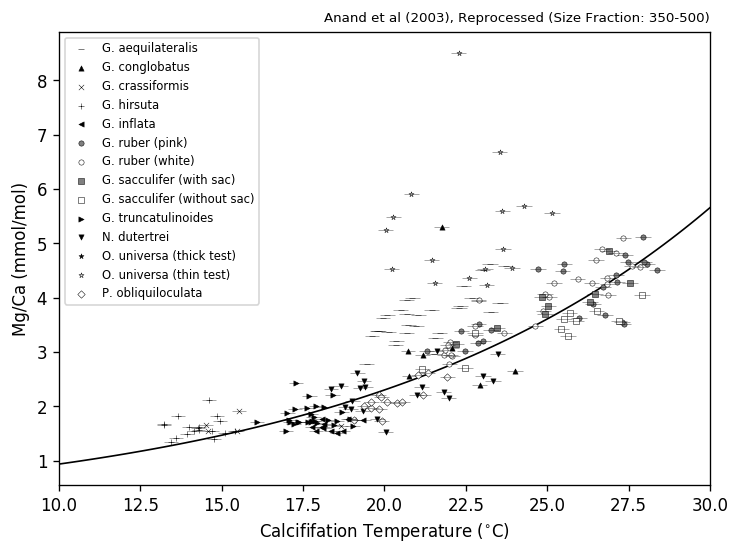

In [153]:
fig, ax = plt.subplots(1,1, figsize=[7, 5])  # create figure with one axis

sf = '350-500'  # identify size fraction to plot

# plot each species separately
for s, d in ad.groupby(level=0, sort=False):  # this loops through all species in the data
    m, c = sdict[s]  # fetch marker and colour information
    # plot data for that species
    ax.scatter(un.nominal_values(d.loc[:, ('Ctemp_mid', sf)]), 
               d.loc[:, ('Mg/Ca', sf)],
               marker=m, c=c, edgecolor='k', s=10,
               lw=0.3, label=s)

# draw a legend on the plot
ax.legend(fontsize=7)

# draw calcification temperature error bars
ax.errorbar(un.nominal_values(ad.loc[:, ('Ctemp_mid', sf)]), 
            ad.loc[:, ('Mg/Ca', sf)],
            xerr=un.std_devs(ad.loc[:, ('Ctemp_mid', sf)]),
            lw=0, elinewidth=0.5, c=(0,0,0,0.4))

# plot Anand multi-species calibration line
Tn = np.linspace(10,30, 100)
mgcan = 0.38 * np.exp(Tn * 0.09)
ax.plot(Tn, mgcan, c='k', lw=1, zorder=-2)

# axis limits
ax.set_xlim(10,30)
# axis labels
ax.set_title('Anand et al (2003), Reprocessed (Size Fraction: ' + sf + ')',
             loc='right', fontsize=8)
ax.set_xlabel('Calcififation Temperature ($^{\circ}C$)', fontsize=10)
ax.set_ylabel('Mg/Ca (mmol/mol)', fontsize=10)

### For reference:

![Fig6](figures/Anand2003_Fig6.png)


## Finally: Export Data

In [144]:
ad.to_csv('data/Anand2003_Reprocessed.csv')

## Closing Comments

The methods described by Anand et al (2003) were insufficient to exactly reproduce the figures in their paper, and the raw data behind the figures was not published. The re-calculation above had to essentially start from scratch, and re-assess the dataset. The fact that we produced a very similar result is encouraging, and suggests their result is robust, but this puts considerable burden on the reader, and *we should not need to do this*.

I hope the above has demonstrated:
1. That you should take care when publishing raw data. It took me a solid hour to get Anand et al's raw data in a sensible format - it's a simple dataset, and it shouldn't have.
2. That your methods should contain enough information to *quantitatively* reproduce your results.
3. That it would be even better to just include something like this, and have it all out in the open!
4. That Python is great :D
